<a href="https://colab.research.google.com/github/shellerbrand/machine-learning-for-object-recognition/blob/master/machine_learning_object_recognition_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferlernen - Objekterkennung mit Neuronalen Netzen

Das Erkennen von Objekten ist eine Aufgabe, die der Mensch ausgezeichnet beherrscht. Auch Computer sind inzwischen mit Hilfe von künstlichen neuronalen Netzen in der Lage, diese Aufgabe in spezifischen Fällen sehr zuverlässig zu erledigen.

Besonders leistungsfähig is hierbei die Klasse der Convolutional Neural Networks (ConvNets). Diese Netze bestehen aus einer Folge von Schichten. Die Ausgänge der ersten Schichten entsprechen dabei der Bildzusammensetzung auf Pixel-Ebene, wohingegen die Ausgänge späterer Schichten immer großflächigere Zusammenhänge beschreiben.



##  Vorarbeiten

Diese Schritte müssen nur einmal ausgeführt werden.

In [1]:
#@title Das Machine Learning Framework (PyTorch) laden 
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# Vision fokussierten Teil von PyTorch
!pip install torchvision
!pip install pillow==4.1.1

# Plotting etc imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn
import time
import os
import copy

# Zufallszahlen Initialisierung fuer das Machine Learning Framework
seed=2
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True


%matplotlib inline
seaborn.set_style("white")
plt.rcParams['figure.dpi'] = 150

In [2]:
#@title Hilfsfunktionen für Training and Visualisierung laden

# 
# Funktionen um Bilder zu laden vom Image-Upload Tool
#

print('Laden von Funktionen zum Laden der Trainings- und Evaluations-Bilder.')

import requests
import os
import shutil
import re

HOST = 'https://imageupload.hellerbit.com'
API_KEY = 'bce8a814f0b3882ac6f2810464128b42dbfee105e1ba84311a77b3f4'
DIR = './tmp/'
TRAINING = 'training'
EVALUATION = 'evaluation'
EXP_TRAIN_A = '1_training_kategorie_A'
EXP_TRAIN_B = '1_training_kategorie_B'
EXP_EVALUATION_A = '1_evaluation_kategorie_A'
EXP_EVALUATION_B = '1_evaluation_kategorie_B'
OUTDIR = './output/'

REGEX_CAT_EXPERIMENT = re.compile('.*_kategorie_(.*)')


if not os.path.isdir(DIR):
    print('Making the directory: {}'.format(DIR))
    os.makedirs(DIR)

def clear_dir():
    expdir = os.path.join(DIR, TRAINING)
    if os.path.isdir(expdir):
        shutil.rmtree(expdir)
    expdir = os.path.join(DIR, EVALUATION)
    if os.path.isdir(expdir):
        shutil.rmtree(expdir)

def download_experiment_images(experiment_id, trainoreval):
  
    cat = REGEX_CAT_EXPERIMENT.search(experiment_id).group(1)
    
    
    url = ''.join([HOST, '/api/{}/all.txt'.format(experiment_id)])
    headers = {'APIKEY': API_KEY}
    resp = requests.get(url, headers=headers)

    print(resp.text)
    files = resp.text.split('\n')
    # Make the directory for the experiment
    expdir = os.path.join(DIR, trainoreval, cat)
    if not os.path.isdir(expdir):
            os.makedirs(expdir)

    for line in files:
        print("Loading this file: {}".format(line))
        url = ''.join([HOST, '/api/{}/{}'.format(experiment_id, line)])
        path = os.path.join(expdir, line)
        print("\t from URL {}".format(url))
        r = requests.get(url, stream=True, headers=headers)
        if r.status_code == 200:
            with open(path, 'wb') as f:
                for chunk in r:
                    f.write(chunk)
                    

print('Laden von Funktionen zum Training und zur Visualisierung.')
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoche {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [TRAINING, EVALUATION]:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == TRAINING):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == TRAINING:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Fehler: {:.4f} Genauigkeit: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == EVALUATION and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training abgeschlossen in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Beste Testgenauigkeit: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[EVALUATION]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
#             print(torch.exp(outputs[0]))
#             print(torch.sum(torch.exp(outputs[0])))            
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure()
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
                plt.axis('off')
                plt.title('Vorhersage: {}'
                          .format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

        
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Is the CUDA Accelerator available?
print("GPU Acceleration: {}".format(torch.cuda.is_available()))


#@title Hilfs-Funktionen laden (werden für Laden und Anzeigen der Bilder benötigt)



Laden von Funktionen zum Laden der Trainings- und Evaluations-Bilder.
Laden von Funktionen zum Training und zur Visualisierung.
GPU Acceleration: True


## Bilder hochladen

Im Folgenden werden die Bilder importiert, die für das Training der Objekterkennung benutzt werden. Es wird hier bewusst eine Kategorien mit dem Namen *A* und *B* verwendet, da man so mit verschiedenen Objektklassen experimentieren kann. In unserem Beispiel nutzen wir zwei verschiedene Arten von Süßigkeiten:

- __Kategorie A__: Gummibärchen
- __Kategorie B__: Lakritze

### Trainingsbilder

Die *Trainingsbilder* sind dafür da, dem Netz beizubringen, wie Objekte der jeweiligen Klasse aussehen. Die Trainingsbilder könnt Ihr z.B. mit dem Handy auf folgenden Links hochladen:

- __Kategorie A__ (Gummibärchen): https://imageupload.hellerbit.com/images/1_training_kategorie_A
- __Kategorie B__ (Lakritze): https://imageupload.hellerbit.com/images/1_training_kategorie_B

### Testbilder

Außerdem brauchen wir noch Bilder, mit denen die Leistungsfähigkeit gemessen werden soll, nachdem das Netz  anhand der *Trainingsbilder* gelernt hat, die zwei Klassen zu unterscheiden. Die *Testbilder* können über folgende Links hochgeladen werden:

- __Kategorie A__ (Gummibärchen): https://imageupload.hellerbit.com/images/1_evaluation_kategorie_A
- __Kategorie B__ (Lakritze): https://imageupload.hellerbit.com/images/1_evaluation_kategorie_B



In [3]:
#@title Den Schlüssel zum Download der Bilder hier eingeben
API_KEY = "3c7f5f9a4d227972f0989cb7c1be7ad0835990d03f84ed8efbae839a" #@param {type:"string"}

clear_dir()
download_experiment_images(EXP_TRAIN_A, TRAINING)
download_experiment_images(EXP_TRAIN_B, TRAINING)
download_experiment_images(EXP_EVALUATION_A, EVALUATION)
download_experiment_images(EXP_EVALUATION_B, EVALUATION)


data_dir = DIR

IMG_2104.jpg
IMG_2105.jpg
IMG_2106.jpg
IMG_2107.jpg
IMG_2108.jpg
IMG_2109.jpg
IMG_2110.jpg
IMG_2111.jpg
IMG_2112.jpg
IMG_2113.jpg
IMG_2114.jpg
IMG_2115.jpg
IMG_2116.jpg
IMG_2117.jpg
IMG_2118.jpg
IMG_2119.jpg
IMG_2120.jpg
IMG_2121.jpg
IMG_2122.jpg
IMG_2123.jpg
IMG_2124.jpg
IMG_2125.jpg
IMG_2126.jpg
IMG_2127.jpg
IMG_2128.jpg
IMG_2130.jpg
IMG_2131.jpg
IMG_2132.jpg
IMG_2133.jpg
IMG_2134.jpg
IMG_2135.jpg
IMG_2136.jpg
IMG_2137.jpg
IMG_2138.jpg
IMG_2139.jpg
IMG_2140.jpg
IMG_2141.jpg
IMG_2142.jpg
IMG_2143.jpg
IMG_2144.jpg
IMG_2148.jpg
IMG_2149.jpg
IMG_2152.jpg
IMG_2153.jpg
IMG_2154.jpg
IMG_2155.jpg
IMG_2156.jpg
IMG_2157.jpg
IMG_2158.jpg
IMG_2159.jpg
IMG_2160.jpg
IMG_2161.jpg
IMG_2162.jpg
IMG_2163.jpg
IMG_2164.jpg
IMG_2166.jpg
IMG_2167.jpg
IMG_2168.jpg
IMG_2169.jpg
IMG_2170.jpg
IMG_2171.jpg
IMG_2172.jpg
IMG_2173.jpg
IMG_2174.jpg
IMG_2175.jpg
IMG_2176.jpg
IMG_2177.jpg
IMG_2178.jpg
IMG_2179.jpg
IMG_2180.jpg
IMG_2181.jpg
IMG_2182.jpg
IMG_2183.jpg
IMG_2184.jpg
IMG_2185.jpg
IMG_2187.jpg
IMG_2188.jpg

In [4]:
#@title Bild-Daten ergänzen um Vergrößerung, Drehung, Farbnormalisierung etc.

data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'evaluation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [TRAINING, EVALUATION]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in [TRAINING, EVALUATION]}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAINING, EVALUATION]}
class_names = image_datasets[TRAINING].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Es gibt folgende Klassen: {}".format(", ".join(_ for _ in class_names )))
print("Training: {} Bilder".format(dataset_sizes[TRAINING]))
print("Test: {} Bilder".format(dataset_sizes[EVALUATION]))
      

Es gibt folgende Klassen: A, B
Training: 197 Bilder
Test: 44 Bilder


## Training

Augmented Set: 50


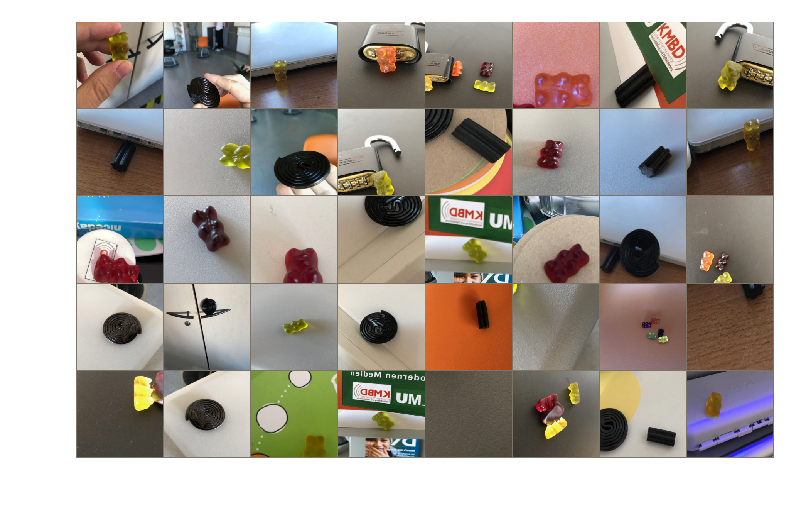

In [5]:
#@title Beispielbilder für das Training anzeigen
n_batch = 10

print('Augmented Set: {}'.format(len(dataloaders[TRAINING])))

# Get a batch of training data
inputs = torch.cat([next(iter(dataloaders[TRAINING]))[0] for _ in range(n_batch)], dim=0)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
imshow(out, title=None)

In [8]:
#@title Das Model trainieren, so dass neue Kategorien erkannt werden.
training_epochen = 5 #@param {type:"slider", min:1, max:25, step:1}

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=training_epochen)

Epoche 0/1
----------
training Fehler: 0.3508 Genauigkeit: 0.8376
evaluation Fehler: 0.1244 Genauigkeit: 0.9773

Epoche 1/1
----------
training Fehler: 0.1757 Genauigkeit: 0.9391
evaluation Fehler: 0.0897 Genauigkeit: 0.9545

Training abgeschlossen in 0m 17s
Beste Testgenauigkeit: 0.977273


## Auswertung

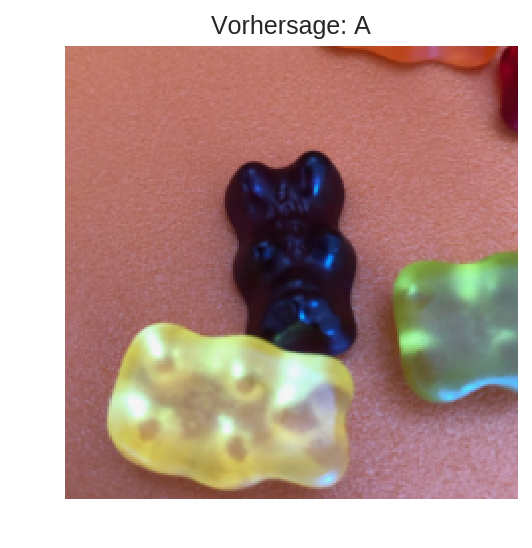

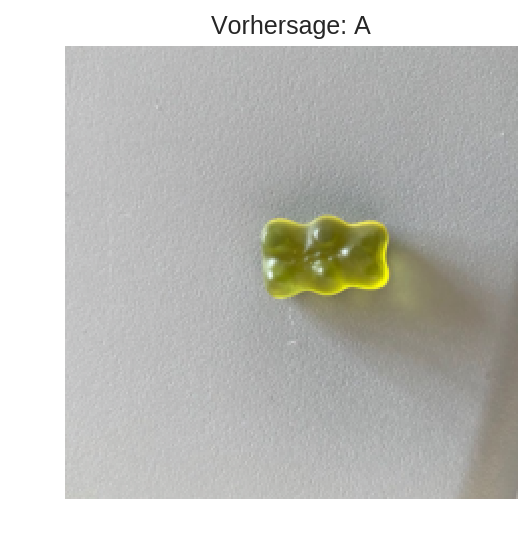

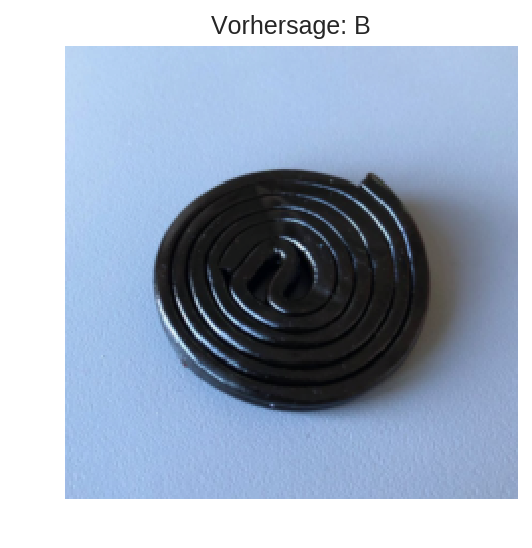

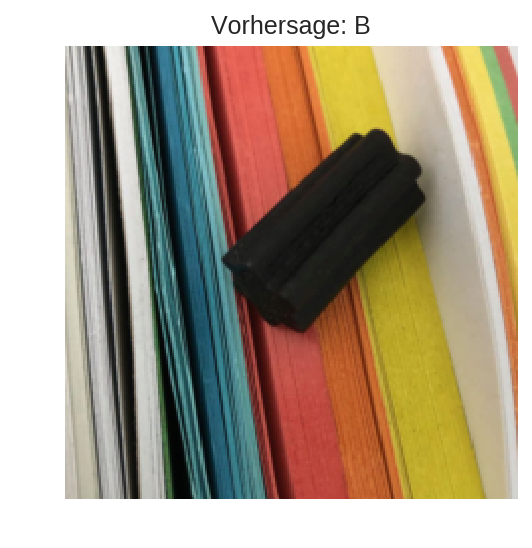

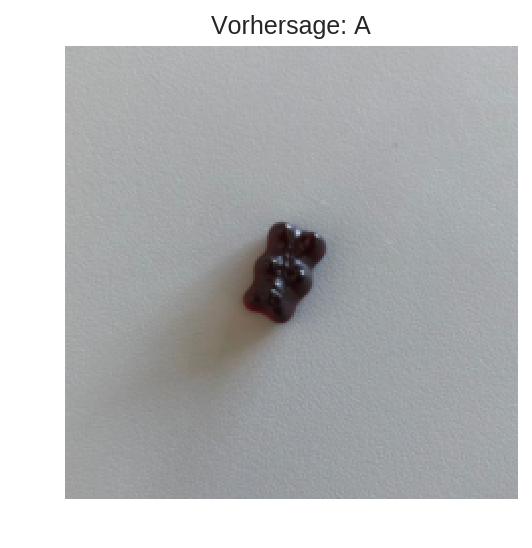

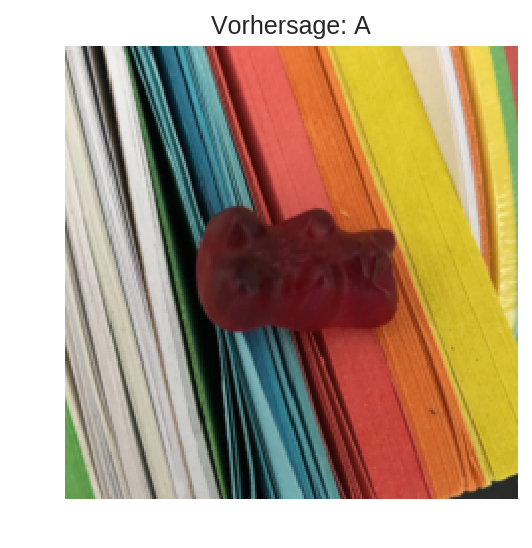

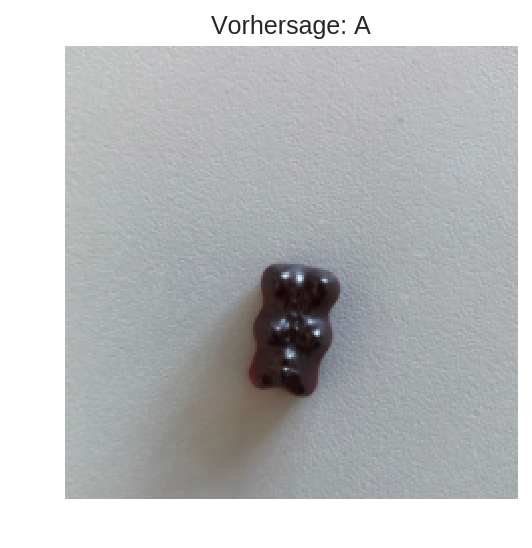

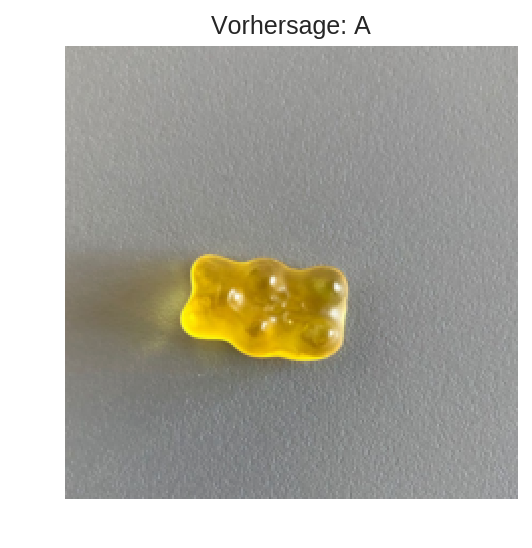

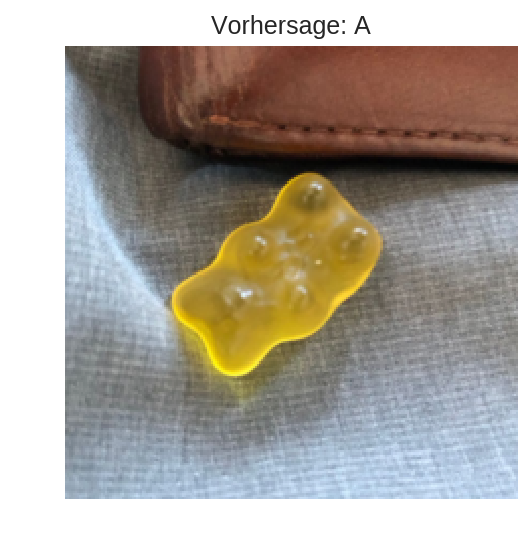

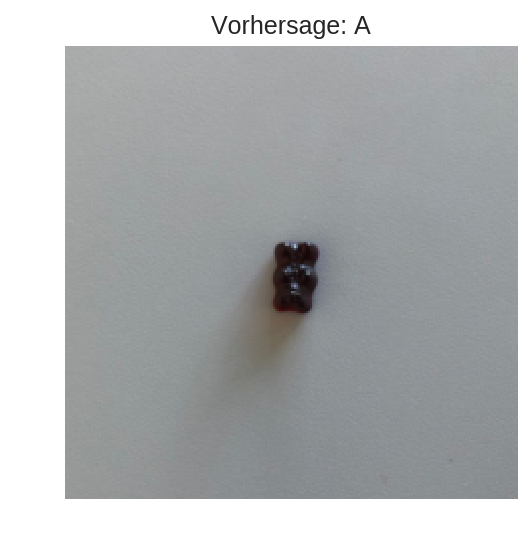

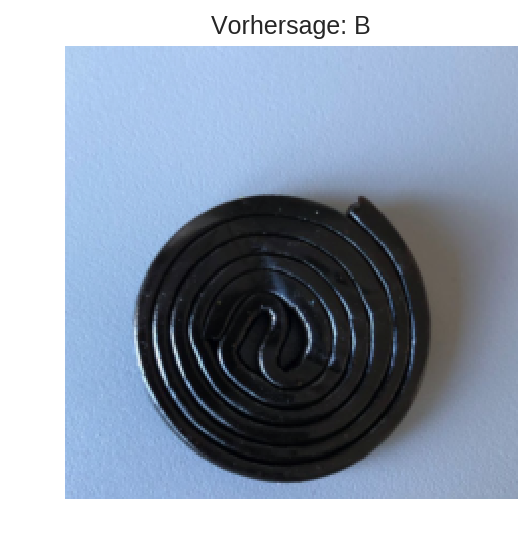

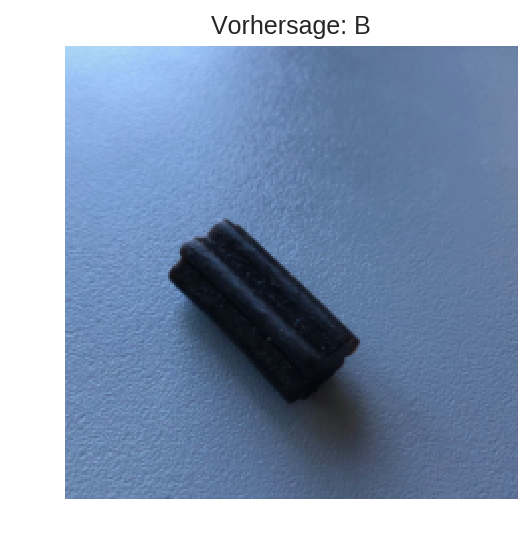

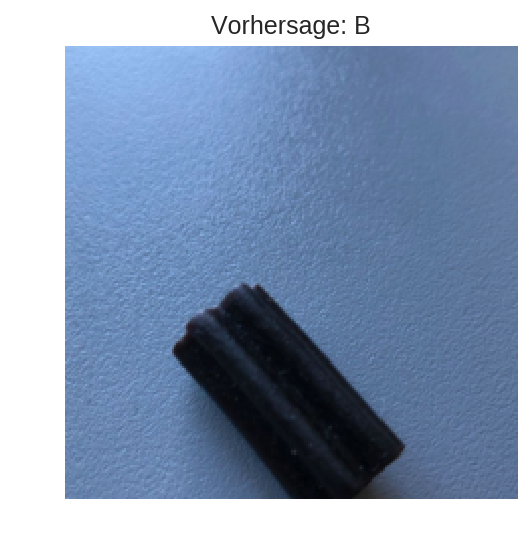

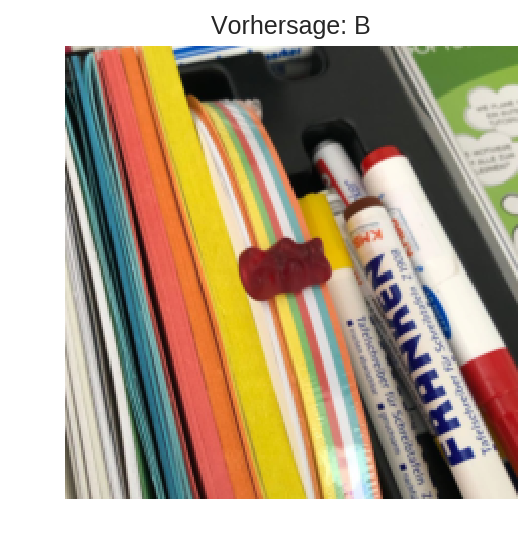

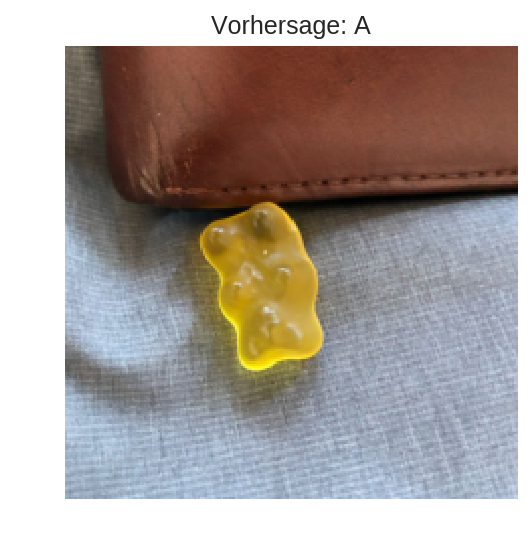

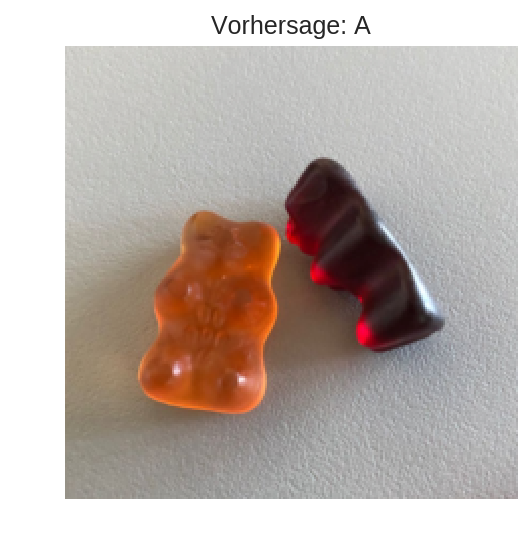

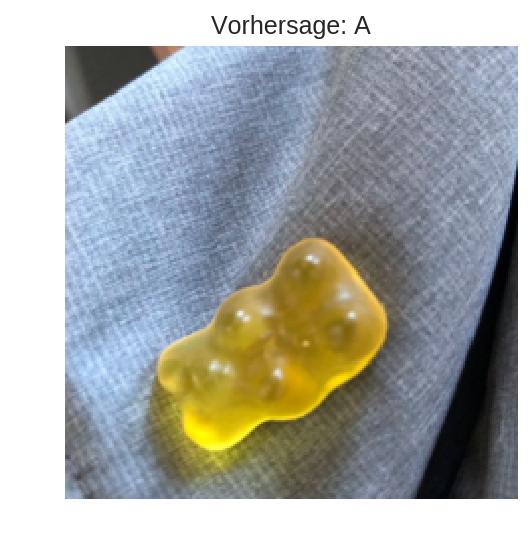

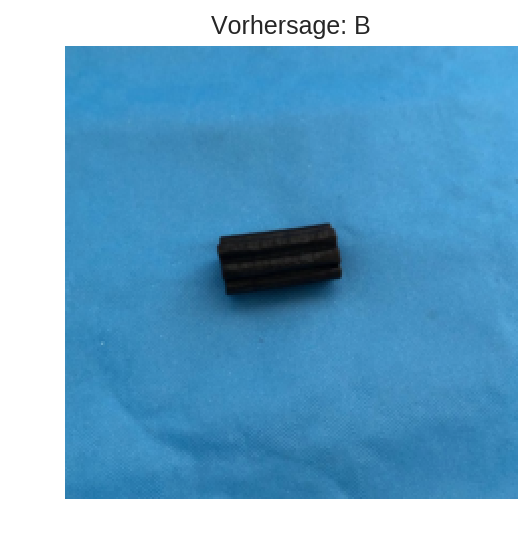

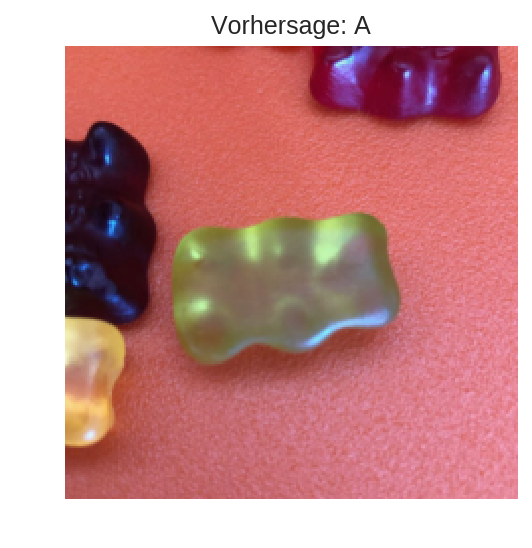

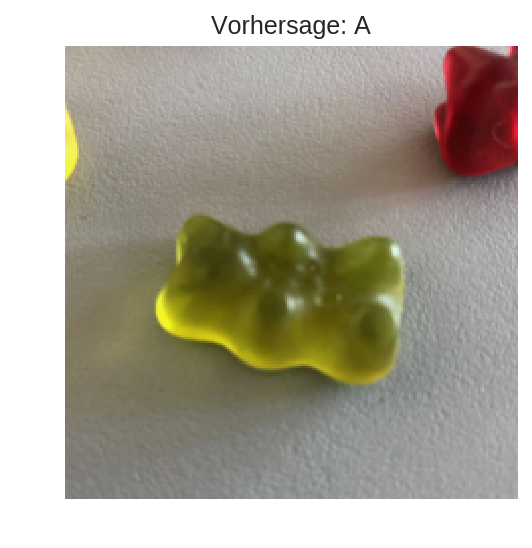

In [9]:
visualize_model(model_conv, 20)

---

## Referenzen

* Chilamkurthy, S; PyTorch Transfer Learning Tutorial, Version Dec 2018, [PyTorch Docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* He, K. et al.; 
Deep Residual Learning for Image Recognition, Dec 2015, [arxiv](https://arxiv.org/abs/1512.03385) (RESNET-18 ConvNet)

Der Source-Code für dieses Notebook und das Tool zum Bilder hochladen sind bzw. werden hier veröffentlicht:

https://github.com/shellerbrand/machine-learning-for-object-recognition

